# Data Cleaning & Augmentation

## Load Wine Review Data

Libraries

In [1]:
import os
import pandas as pd
import numpy as np
import kagglehub

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

Source: Kaggle [Wine Reviews](https://www.kaggle.com/datasets/zynicide/wine-reviews)

In [2]:
# read the local clean dataset
reviews = pd.read_parquet('files/wine_review.parquet.gzip')
reviews.info()
reviews.head()

<class 'pandas.core.frame.DataFrame'>
Index: 100538 entries, 0 to 129970
Data columns (total 15 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   country         100538 non-null  object 
 1   description     100538 non-null  object 
 2   points          100538 non-null  int64  
 3   price           93522 non-null   float64
 4   taster_name     100538 non-null  object 
 5   title           100538 non-null  object 
 6   variety         100538 non-null  object 
 7   winery          100538 non-null  object 
 8   year            100538 non-null  int64  
 9   wine_style      100538 non-null  object 
 10  type            100538 non-null  object 
 11  quality         100538 non-null  object 
 12  classification  100538 non-null  object 
 13  location        100538 non-null  object 
 14  band            93522 non-null   object 
dtypes: float64(1), int64(2), object(12)
memory usage: 12.3+ MB


,country,description,points,price,taster_name,title,variety,winery,year,wine_style,type,quality,classification,location,band
0,Italy,"Aromas include tropical fruit, broom, brimston...",87,NaN,Kerin O’Keefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia,2013,light_white,white,medium,Old World,Etna,None
1,Portugal,"This is ripe and fruity, a wine that is smooth...",87,15.0,Roger Voss,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos,2011,medium_red,red,medium,Old World,Douro,popular
2,US,"Tart and snappy, the flavors of lime flesh and...",87,14.0,Paul Gregutt,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm,2013,light_white,white,medium,New World,Oregon,popular
3,US,"Pineapple rind, lemon pith and orange blossom ...",87,13.0,Alexander Peartree,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian,2013,aromatic_white,white,medium,New World,Michigan,popular
4,US,"Much like the regular bottling from 2012, this...",87,65.0,Paul Gregutt,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks,2012,light_red,red,medium,New World,Oregon,luxury


## Preprocess

**Simplified Preprocessor Helper**

Omits Named Entity Recognition for speed.

In [3]:
import os
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from joblib import Parallel, delayed
import contractions
from unidecode import unidecode

# stop words
swords = stopwords.words('english')

# preprocessing steps collected into a single method
def preprocess(description, lemmatize=True):
  # words to keep
  keep = lambda word: (word not in string.punctuation) and (word not in swords)
  # normalize
  normalize = WordNetLemmatizer().lemmatize if lemmatize else PorterStemmer().stem

  # run the simplified tokenization and normalization pipeline
  return ' '.join(map(normalize, filter(keep, map(lambda word: word.lower(), word_tokenize(contractions.fix(unidecode(description, errors="preserve")))))))

# parallel processing implementation
def joblib_preprocess(func, corpus):
  return pd.Series(Parallel(n_jobs=os.cpu_count(), verbose=0)(delayed(func)(doc) for doc in corpus), index=corpus.index)

# abstraction for parallel preprocessing alternative
parallel_preprocess = lambda corpus, func=preprocess: joblib_preprocess(func, corpus)

**Tokenize and normalize the `description`**

In [4]:
#tokenize the description
reviews['normalized_description'] = parallel_preprocess(reviews.description)
reviews[['country', 'winery', 'variety', 'year', 'description', 'normalized_description']]

,country,winery,variety,year,description,normalized_description
0,Italy,Nicosia,White Blend,2013,"Aromas include tropical fruit, broom, brimston...",aroma include tropical fruit broom brimstone d...
1,Portugal,Quinta dos Avidagos,Portuguese Red,2011,"This is ripe and fruity, a wine that is smooth...",ripe fruity wine smooth still structured firm ...
2,US,Rainstorm,Pinot Gris,2013,"Tart and snappy, the flavors of lime flesh and...",tart snappy flavor lime flesh rind dominate gr...
3,US,St. Julian,Riesling,2013,"Pineapple rind, lemon pith and orange blossom ...",pineapple rind lemon pith orange blossom start...
4,US,Sweet Cheeks,Pinot Noir,2012,"Much like the regular bottling from 2012, this...",much like regular bottling 2012 come across ra...
...,...,...,...,...,...,...
129966,Germany,Dr. H. Thanisch (Erben Müller-Burggraef),Riesling,2013,Notes of honeysuckle and cantaloupe sweeten th...,note honeysuckle cantaloupe sweeten deliciousl...
129967,US,Citation,Pinot Noir,2004,Citation is given as much as a decade of bottl...,citation given much decade bottle age prior re...
129968,France,Domaine Gresser,Gewürztraminer,2013,Well-drained gravel soil gives this wine its c...,well-drained gravel soil give wine crisp dry c...
129969,France,Domaine Marcel Deiss,Pinot Gris,2012,"A dry style of Pinot Gris, this is crisp with ...",dry style pinot gris crisp acidity also weight...


In [5]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
Index: 100538 entries, 0 to 129970
Data columns (total 16 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   country                 100538 non-null  object 
 1   description             100538 non-null  object 
 2   points                  100538 non-null  int64  
 3   price                   93522 non-null   float64
 4   taster_name             100538 non-null  object 
 5   title                   100538 non-null  object 
 6   variety                 100538 non-null  object 
 7   winery                  100538 non-null  object 
 8   year                    100538 non-null  int64  
 9   wine_style              100538 non-null  object 
 10  type                    100538 non-null  object 
 11  quality                 100538 non-null  object 
 12  classification          100538 non-null  object 
 13  location                100538 non-null  object 
 14  band                    9

**Tokenize and normalize `title`**

In [6]:
#tokenize the title
reviews['normalized_title'] = parallel_preprocess(reviews.title)
reviews[['country', 'winery', 'variety', 'year', 'title', 'normalized_title']]

,country,winery,variety,year,title,normalized_title
0,Italy,Nicosia,White Blend,2013,Nicosia 2013 Vulkà Bianco (Etna),nicosia 2013 vulka bianco etna
1,Portugal,Quinta dos Avidagos,Portuguese Red,2011,Quinta dos Avidagos 2011 Avidagos Red (Douro),quinta do avidagos 2011 avidagos red douro
2,US,Rainstorm,Pinot Gris,2013,Rainstorm 2013 Pinot Gris (Willamette Valley),rainstorm 2013 pinot gris willamette valley
3,US,St. Julian,Riesling,2013,St. Julian 2013 Reserve Late Harvest Riesling ...,st. julian 2013 reserve late harvest riesling ...
4,US,Sweet Cheeks,Pinot Noir,2012,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,sweet cheek 2012 vintner 's reserve wild child...
...,...,...,...,...,...,...
129966,Germany,Dr. H. Thanisch (Erben Müller-Burggraef),Riesling,2013,Dr. H. Thanisch (Erben Müller-Burggraef) 2013 ...,dr. h. thanisch erben muller-burggraef 2013 br...
129967,US,Citation,Pinot Noir,2004,Citation 2004 Pinot Noir (Oregon),citation 2004 pinot noir oregon
129968,France,Domaine Gresser,Gewürztraminer,2013,Domaine Gresser 2013 Kritt Gewurztraminer (Als...,domaine gresser 2013 kritt gewurztraminer alsace
129969,France,Domaine Marcel Deiss,Pinot Gris,2012,Domaine Marcel Deiss 2012 Pinot Gris (Alsace),domaine marcel deiss 2012 pinot gris alsace


**Check for null Preprocesing results**

In [7]:
reviews.isna().sum()

country                      0
description                  0
points                       0
price                     7016
taster_name                  0
title                        0
variety                      0
winery                       0
year                         0
wine_style                   0
type                         0
quality                      0
classification               0
location                     0
band                      7016
normalized_description       0
normalized_title             0
dtype: int64

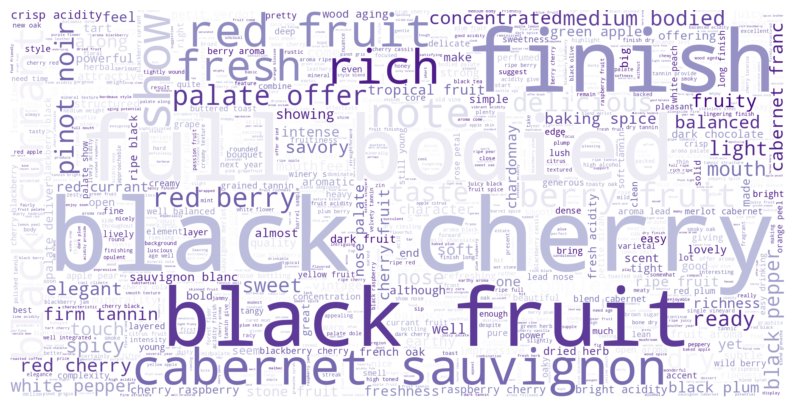

In [19]:
import wordcloud as wc

# https://medium.com/@m3redithw/wordclouds-with-python-c287887acc8b

# helper Function for display frequency of words
def freq_words(words, title=None, show_v=False):
  '''
  Show frequency of words as an image
  '''

  stopwords = set(wc.STOPWORDS)
  stopwords.update(["drink", "now", "wine", "flavor", "flavors"])

  # Generate frequency of words as an image
  freq_words_img = wc.WordCloud(stopwords=stopwords, background_color='white', colormap='Purples', width=2048,height=1024, max_words=1000).generate(words)

  # print the vector of words extracted from the description
  if show_v:
    print(freq_words_img.words_)

  # Display the image
  plt.figure(figsize=(10, 10))
  if title is not None:
    plt.title(title)
  plt.imshow(freq_words_img, interpolation="bilinear")
  plt.axis("off")
  plt.show()

# show a word cloud of the features extracted from the description
freq_words(' '.join(reviews.normalized_description))

## Train-Test Data Split

Split the test data set before extracting features through things like TF-IDF that operate on the corpus being trained.

In [8]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(reviews.drop(['price', 'band', 'quality', 'points', 'taster_name', 'location'], axis=1), reviews.quality, stratify=reviews.quality, test_size=0.2, random_state=42)

## Vectorize

In [9]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

def vectorize(vectorizer, corpus):
  dtm = vectorizer.fit_transform(corpus)
  features = pd.DataFrame(dtm.toarray(), columns = vectorizer.get_feature_names_out())
  return features

**Bag-of-words**: count occurrence of words in a single description

In [10]:
description_train_bow = vectorize(CountVectorizer(), X_train.normalized_description)
description_train_bow.info()
description_train_bow.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80430 entries, 0 to 80429
Columns: 24185 entries, 000 to zwiegelt
dtypes: int64(24185)
memory usage: 14.5 GB


,000,008,01,02,03,030,035,04,04s,05,...,zoomed,zooming,zorro,zu,zucca,zuccardi,zucchini,zull,zweigelt,zwiegelt
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [11]:
title_train_bow = vectorize(CountVectorizer(), X_train.normalized_title)
title_train_bow.info()
title_train_bow.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80430 entries, 0 to 80429
Columns: 26301 entries, 006 to zynthesis
dtypes: int64(26301)
memory usage: 15.8 GB


,006,01,05,068,075,08,086,09,10,100,...,zunino,zurinaga,zusslin,zweigelt,zwerithaler,zwirch,zydeco,zygos,zyme,zynthesis
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


**TF-IDF**: importance of token in document relative to entire corpus

In [12]:
description_train_tfidf = vectorize(TfidfVectorizer(), X_train.normalized_description)
description_train_tfidf.info()
description_train_tfidf.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80430 entries, 0 to 80429
Columns: 24185 entries, 000 to zwiegelt
dtypes: float64(24185)
memory usage: 14.5 GB


,000,008,01,02,03,030,035,04,04s,05,...,zoomed,zooming,zorro,zu,zucca,zuccardi,zucchini,zull,zweigelt,zwiegelt
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
title_train_tfidf = vectorize(TfidfVectorizer(), X_train.normalized_title)
title_train_tfidf.info()
title_train_tfidf.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80430 entries, 0 to 80429
Columns: 26301 entries, 006 to zynthesis
dtypes: float64(26301)
memory usage: 15.8 GB


,006,01,05,068,075,08,086,09,10,100,...,zunino,zurinaga,zusslin,zweigelt,zwerithaler,zwirch,zydeco,zygos,zyme,zynthesis
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
